# Continuous Time 2D Model

We model the example of short-lived temperature sensors on the plane $[0,1]^2$ in continuous time, using a combination of a queueing model and point process. Throughout the setup of the model, fix a time $T;$ for each time $t \in [0,T]$ the set of sensors $S_t$ at time $t$ is a set of locations on $\mathbb{R}^2,$ where $|S_t|$ is a random variable, and $S_t(i),$ the location of the $i$th sensor is uniformly sampled from the uniform measure on $[0,1]^2$.

Perhaps the easiest way to set up the model is via a (FIFO) queueing model, or birth-death process representing the sensors:

- We start with $L_0$ number of sensors, each sampled uniformly from the sphere. 
- Sensors are added to the queue every so often, again sampled uniformly from the sphere. 
- Independently of the creation of new sensors, sensors break down at a perhaps different rate, and leave the queue.

We can model the time between consecutive joining/ exiting of the queue by exponential distributions.


## Queueing Model Implementation
Consider a queueing model whose initial length is $L_0,$ the number of initial sensors we begin with. We assume that the queue processes sensors (physically: sensors break down) in a random time $\sim \text{Exp}(\lambda_1),$ and sensors join the queue with interarrival times distributed according to $\text{Exp}(\lambda_2),$ which are independent of the times it takes for the queue to process the input.

We can simulate this queue in the following way. For a given fixed time $t \in [0,T],$ by the memoryless property of exponential distributions, the time until a sensor leaves the queue is still $X_1 \sim \text{Exp}(\lambda_1)$ and the interarrival time is still distributed according to $X_2 \text{Exp}(\lambda_2).$ Now, the time until one of these two actions occurs is a random variable $Z = \min(X_1,X_2) \sim \text{Exp}(\lambda_1+\lambda_2)$ (which can be checked). Now the probability that a sensor joins the queue first is $\mathbb{P}(X_1 > X_2) = \frac{\lambda_1}{\lambda_1 + \lambda_2},$ and one minus that for the probability that a sensor breaks and leaves the queue. We can then model the process by waiting $\text{Exp}(\lambda_1+\lambda_2)$ amount of time, and with probability $\frac{\lambda_1}{\lambda_1 + \lambda_2},$ adding a new sensor to the queue, or otherwise removing the oldest sensor from the queue.

## Dynamic Network Analysis
The continuous time model allows us to subsample as finely as we want. We keep track of the birth/death of the sensors in an interval tree; for any $t \in [0,T]$ we query the interval tree for the set of points that are present on the sphere at that time, and then create a dynamic network via the delaunay construction, assigining node values via some observation function representing temperature, or another desired quantity, and the edge weights by distance on the sphere.

In [1]:
# Come up with some periodic function on the [0,1] grid; sample random geometric graphs with the proper connectivitty.


# Do the same in 3D?

## add drift to the function, or some isometry...

In [1]:
from __future__ import division
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import squareform
import importlib
import scipy.spatial as sp

## Load in sphere code
sys.path.append('../data/simple_egs/')
import PlaneExample as plane
import ContinuousTimeSensorModel as ctsm
importlib.reload(ctsm)
importlib.reload(plane)

## Load in d.n. analysis code
sys.path.append('../shared_scripts/')
import graph_fns as gf
import persistence_fns as pf
import sliding_window_fns as sw
from ripser import ripser
from persim import plot_diagrams
from sklearn import manifold

from matplotlib.lines import Line2D
import time 

POT (Python Optimal Transport) package is not installed. Try to run $ conda install -c conda-forge pot ; or $ pip install POT


In [22]:
## Setup Sensor Lifetimes 
max_lifetime = 4

T = 1
#obsfn = lambda t, p: plane.periodic_plane_stationary(t,p,1) # T doesn't matter here
obsfn = lambda t, p: plane.periodic_plane_random_cos_series(t,p,T, seed = 25) # add some sort of isometry. 
# seed 16 = mobius

# can add some random time varying rotation, 
# or on torus can add some noise.

lambda1 = 25
lambda2 = lambda1

start = time.time()
sensor_lifetimes = ctsm.get_sensor_lifetimes(250, max_lifetime, lambda1, lambda2, manifold = 'plane')

end = time.time()
print("Sampling Sensor Lifetimes", end - start) 

Sampling Sensor Lifetimes 0.0785520076751709


In [23]:
#obsfn(1,np.array([[0.5,0.5]]))

In [24]:
## Create the Dynamic Network
step_size = 0.05
ts = np.arange(0,max_lifetime,step_size) 

start = time.time()
(node_wts,edge_wts, allpoints) = ctsm.sample_dynamic_geometric_graph(sensor_lifetimes, ts,
                                                                     obsfn = obsfn, manifold = 'plane')
end = time.time()
print("Sampling Dynamic Network", end - start) 

Sampling Dynamic Network 0.8360037803649902


In [25]:
import multiprocessing as mp
from joblib import Parallel, delayed

start = time.time()
filtration_matrix = list(map(lambda n, e: pf.get_filtration(n, e), node_wts, edge_wts))
end = time.time()
print("Converting to filtration matrices", end - start) 


Converting to filtration matrices 0.09888505935668945


In [26]:
start = time.time()
num_cores = mp.cpu_count() - 4
barcodes = Parallel(n_jobs = num_cores)(delayed(pf.get_rips_complex)(filt) for filt in filtration_matrix)
end = time.time()
print("Computing barcodes", end - start) 

Computing barcodes 0.2866530418395996


In [27]:
nmin = min([np.min(x) for x in node_wts])
nmax = max([np.max(x) for x in node_wts])

In [30]:
len(allpoints)

80

In [31]:
## plot the dynamic network
# plt.figure(figsize = (12,5))

# for i in range(len(allpoints))[100:110]:
#     plt.clf()
#     ax = plt.gcf().add_subplot(121)
#     pts = np.array(allpoints[i])
#     nw = node_wts[i]
    
#     gpts = np.concatenate((pts, np.zeros((2, 2))))
#     gnw = np.concatenate((nw, np.array([nmin, nmax])))
    
        
#     adj = np.argwhere(edge_wts[i].todense() == -np.inf) 
#     for j in range(len(adj)):
        
#         pt1 = pts[adj[j,0]]
#         pt2 = pts[adj[j,1]]
        
#         l = Line2D((pt1[0],pt2[0]), 
#                    (pt1[1],pt2[1]),
#                    linewidth=0.1)
#         ax.add_line(l)
    
#     p = ax.scatter(gpts[:,0], gpts[:,1], c = gnw, s = 20)
#     plt.colorbar(p)
        
# plt.show()

In [32]:
# plt.figure(figsize=(5, 5))
# for i in range(len(barcodes)):
#     plt.clf()
#     plot_diagrams(barcodes[i], xy_range = [nmin,nmax,nmin,nmax])
#     plt.savefig('Images/PlaneMovie/{:04d}.png'.format(i),bbox_inches = 'tight')

In [33]:
start = time.time()
bn_dist_matrix = pf.get_bottleneck_dist_matrix(barcodes)
end = time.time()
print("Computing bottleneck", end - start) 


Computing Row 0
Computing Row 1
Computing Row 2
Computing Row 3
Computing Row 4
Computing Row 5
Computing Row 6
Computing Row 7
Computing Row 8
Computing Row 9
Computing Row 10
Computing Row 11
Computing Row 12
Computing Row 13
Computing Row 14
Computing Row 15
Computing Row 16
Computing Row 17
Computing Row 18
Computing Row 19
Computing Row 20
Computing Row 21
Computing Row 22
Computing Row 23
Computing Row 24
Computing Row 25
Computing Row 26
Computing Row 27
Computing Row 28
Computing Row 29
Computing Row 30
Computing Row 31
Computing Row 32
Computing Row 33
Computing Row 34
Computing Row 35
Computing Row 36
Computing Row 37
Computing Row 38
Computing Row 39
Computing Row 40
Computing Row 41
Computing Row 42
Computing Row 43
Computing Row 44
Computing Row 45
Computing Row 46
Computing Row 47
Computing Row 48
Computing Row 49
Computing Row 50
Computing Row 51
Computing Row 52
Computing Row 53
Computing Row 54
Computing Row 55
Computing Row 56
Computing Row 57
Computing Row 58
Computi

## Visualize dynamic network

In [34]:
#from IPython.display import Video

#Video("test.mp4")

## Persistence Plotting

In [35]:
# import SphereExample as sphere


# ## Vary Window Length and Dimension
# window_length_test_values = np.linspace(0,4.0*T,15)[1:]
# dim_test_values = range(20,25)

# mpers_results = np.zeros((len(window_length_test_values),len(dim_test_values)))
# top_diff_results = np.zeros((len(window_length_test_values),len(dim_test_values)))
# PD_results = {}

# for i,wl in enumerate(window_length_test_values):
#     for j,d in enumerate(dim_test_values):
#         print("/n","New Params:")
#         print("WL over period: ",np.round(wl/T,2)," dimension: ",d)
#         print("sw vector step size (tau): ", int(wl/(d*step_size)))
    
#         # construct a sliding window embedding
#         sw_vecs_indices = sw.sliding_window(range(len(barcodes)), d=d, tau= int(wl/(d*step_size)),
#                                             max_index = int(6.0*T/step_size) )
        
#         print("Number of points in SW Embedding:", len(sw_vecs_indices))
#         sw_dist_matrix = sw.sw_distance_matrix(sw_vecs_indices, bn_dist_matrix)
#         PDs = ripser(sw_dist_matrix, distance_matrix=True, maxdim=1, coeff=5)['dgms']
        
#         PD_results[i,j] = PDs[1]
#         res = (sphere.get_maximum_persistence(PDs)[1],
#                sphere.get_top_diff_persistence(PDs)[1],
#                sphere.get_num_features(PDs)[1])
        

#         mpers_results[i,j] = res[0]
#         top_diff_results[i,j] = res[1]

## Plotting

In [36]:
wl = 2.0*T
d = 10
swe = sw.sliding_window(range(len(barcodes)), d=d, tau= int(wl/(d*step_size)),
                                    max_index = int(6.0*T/step_size) )

print("Number of points in SW Embedding:", len(swe))
sw_dist_matrix = sw.sw_distance_matrix(swe, bn_dist_matrix)

Number of points in SW Embedding: 44


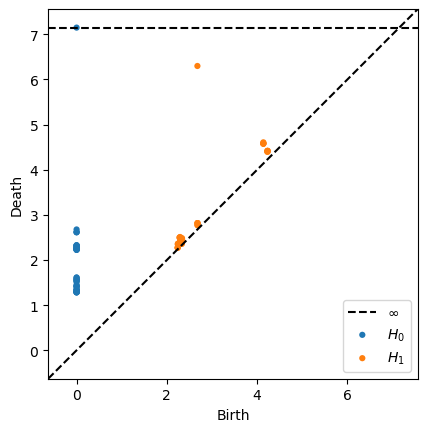

In [37]:
PDs = ripser(sw_dist_matrix, distance_matrix=True, maxdim=1, coeff=3)['dgms']
plot_diagrams(PDs)

/Users/timothysudijono/anaconda3/envs/mypython3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


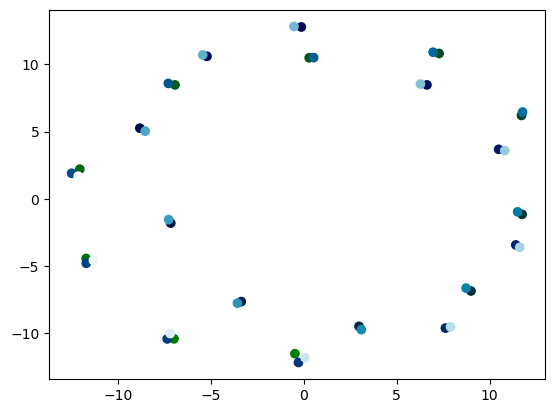

In [38]:
from sklearn.manifold import MDS

embedding = MDS(n_components=2)
X_transformed = embedding.fit_transform(sw_dist_matrix)
X_transformed.shape

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_transformed[:,0],X_transformed[:,1],
           c = np.linspace(0,1,X_transformed.shape[0]),
           cmap = plt.cm.ocean)

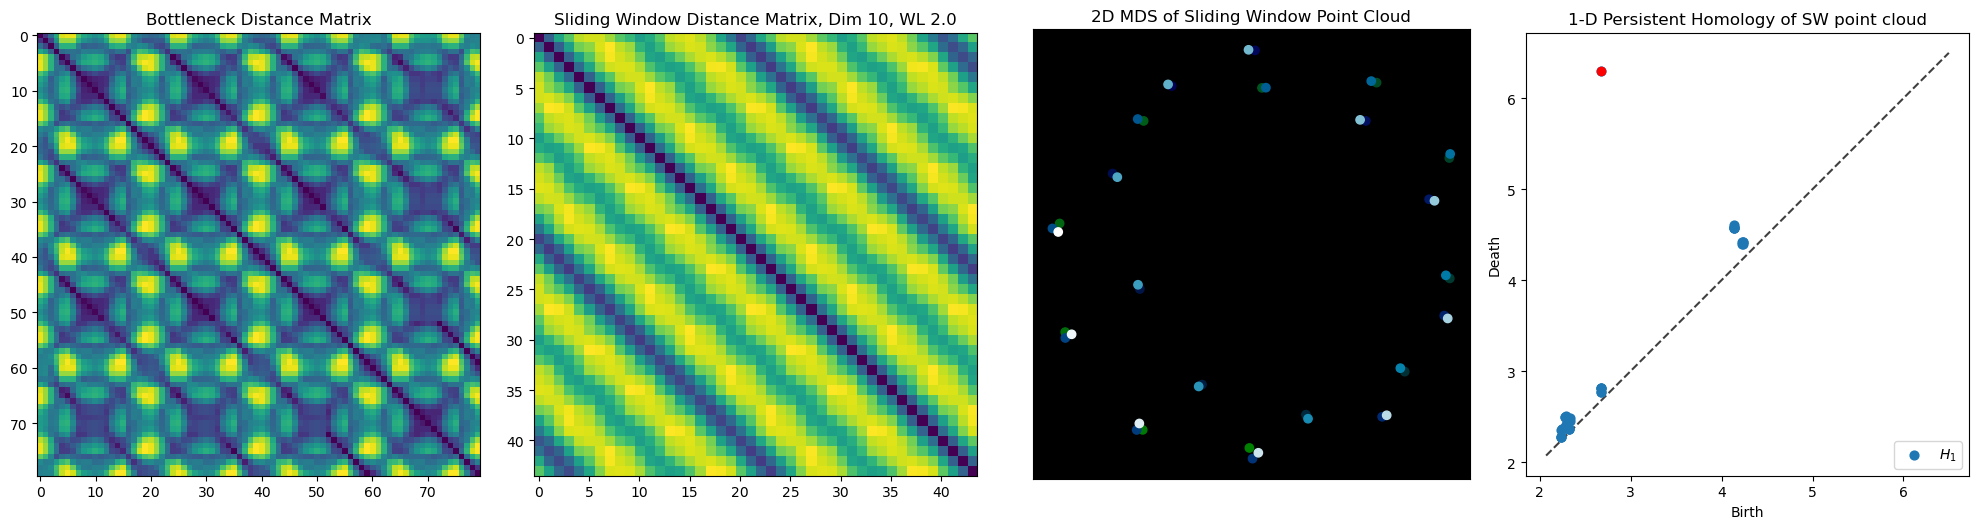

In [39]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20,5))
#fig.suptitle('Continuous Time Plane Example Results')

ax1.imshow(bn_dist_matrix)
ax1.set_title('Bottleneck Distance Matrix')
ax2.imshow(sw_dist_matrix)
ax2.set_title('Sliding Window Distance Matrix, Dim %s, WL %s' %(d,wl))


ax3.scatter(X_transformed[:,0],X_transformed[:,1],
           c = np.linspace(0,1,X_transformed.shape[0]),
           cmap = plt.cm.ocean)
ax3.axes.xaxis.set_visible(False)
ax3.axes.yaxis.set_visible(False)
ax3.set_facecolor('black')
ax3.set_aspect('equal','box')
ax3.set_title('2D MDS of Sliding Window Point Cloud')

# what's the period of the persistence diagram time series? Is it half this?

ax4.scatter(PDs[1][:,0],PDs[1][:,1],s = 40, label = '$H_1$')
ax4.set_title('1-D Homology of Sliding Window Point Cloud')
ax4.legend(loc = 4)
ax4.set_aspect('equal','box')
lims = [
    np.min([ax4.get_xlim(), ax4.get_ylim()]),  # min of both axes
    np.max([ax4.get_xlim(), ax4.get_ylim()]),  # max of both axes
]

a = PDs[1]
sa = a[a[:,1].argsort()]

# now plot both limits against eachother
ax4.set_ylabel('Death')
ax4.set_xlabel('Birth')
ax4.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax4.plot(sa[-1,0],sa[-1,1],'ro', linewidth = 160)
ax4.set_title('1-D Persistent Homology of SW point cloud')
ax4.set_ylabel('Death')
ax4.set_xlabel('Birth')

plt.tight_layout()
plt.savefig('stationary_plane_results.png')

/Users/timothysudijono/anaconda3/envs/mypython3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


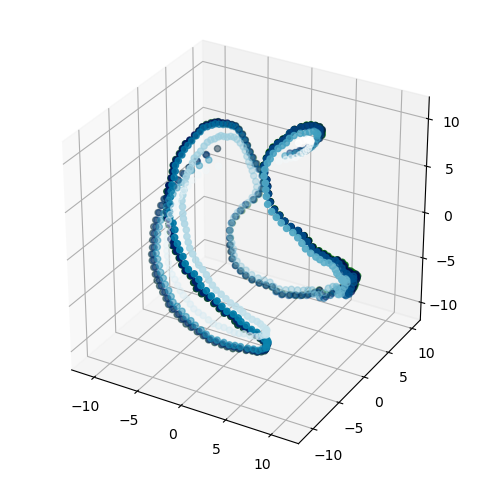

In [18]:
from sklearn.manifold import MDS

embedding = MDS(n_components=3)
X_transformed = embedding.fit_transform(sw_dist_matrix)
X_transformed.shape

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_transformed[:,0],X_transformed[:,1],X_transformed[:,2],
           c = np.linspace(0,1,X_transformed.shape[0]),
           cmap = plt.cm.ocean)

<ipython-input-19-6fc672117889>:27: RuntimeWarning: invalid value encountered in true_divide
  im2 = axs[1].imshow(np.divide(top_diff_results,mpers_results),cmap = plt.cm.magma)


<Figure size 640x480 with 0 Axes>

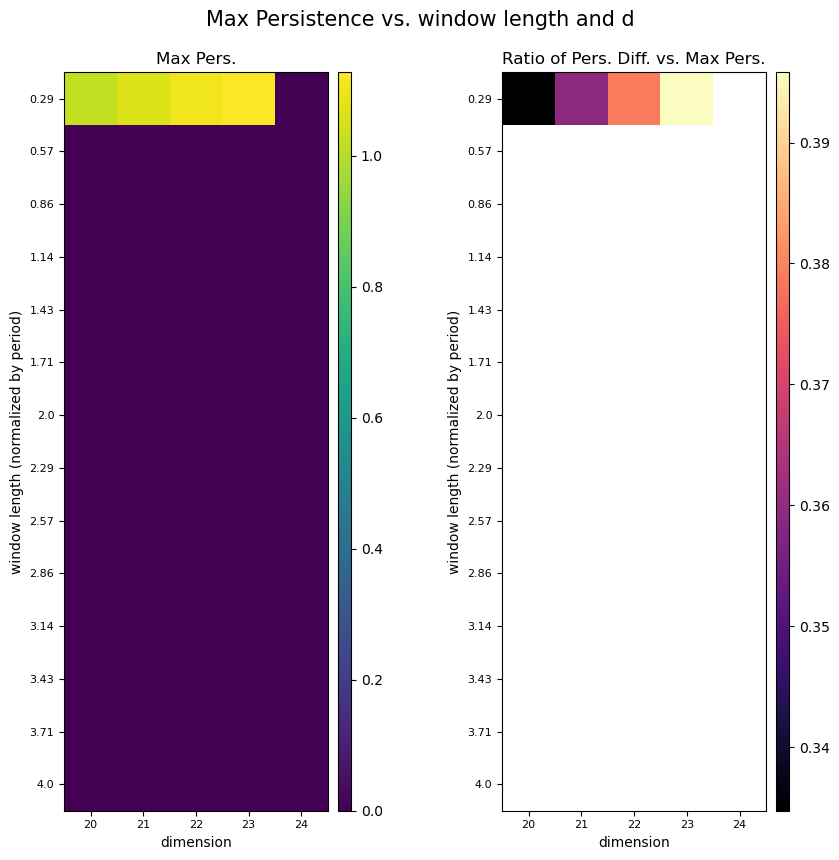

In [19]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.gcf().clear()
fig, axs = plt.subplots(1,2,figsize = (9,9))

ticksize = 8

im1 = axs[0].imshow(mpers_results)

axs[0].set_xlabel('dimension')
axs[0].set_xticks(np.arange(len(dim_test_values)))
axs[0].set_xticklabels(labels = list(dim_test_values),fontsize = ticksize)

axs[0].set_ylabel('window length (normalized by period)')
axs[0].set_yticks(np.arange(len(window_length_test_values)))
axs[0].set_yticklabels(labels = list(np.around(window_length_test_values/T,2)),fontsize = ticksize)

axs[0].set_title('Max Pers.')

divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im1,cax1,orientation = 'vertical')

### Do the other plot ###

im2 = axs[1].imshow(np.divide(top_diff_results,mpers_results),cmap = plt.cm.magma)

axs[1].set_xlabel('dimension')
axs[1].set_xticks(np.arange(len(dim_test_values)))
axs[1].set_xticklabels(labels = list(dim_test_values), fontsize = ticksize)


axs[1].set_ylabel('window length (normalized by period)')
axs[1].set_yticks(np.arange(len(window_length_test_values)))
axs[1].set_yticklabels(labels = list(np.around(window_length_test_values/T,2)),fontsize = ticksize)
axs[1].set_title('Ratio of Pers. Diff. vs. Max Pers.')

divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes('right', size='5%', pad=0.1)
fig.colorbar(im2,cax2)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.suptitle('Max Persistence vs. window length and d', fontsize = 15)
plt.savefig('CtsEx:wl{}dim{}T{}'.format(len(window_length_test_values),len(dim_test_values),T))

plt.show()

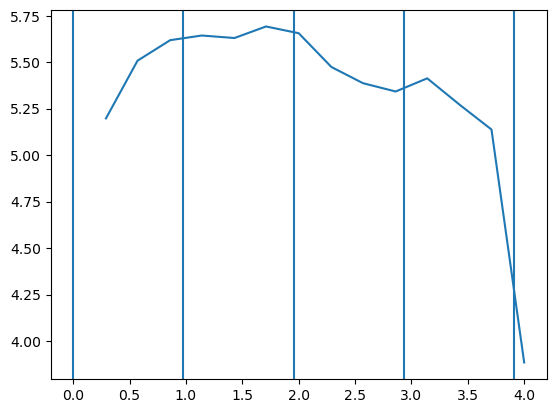

In [25]:
fig,ax = plt.subplots()
ax.plot(np.around(window_length_test_values/T,2),mpers_results[:,-1])
scale = 44.0/45.0
period_length = 1
for x in scale*period_length*np.arange(0,5):
    ax.axvline(x)
plt.show()